In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def display_img(I, label=None):
    %matplotlib inline
    dpi = mpl.rcParams['figure.dpi']
    print('Shape:', I.shape)
    print('dpi:', dpi)
    fig = plt.figure(figsize=( I.shape[0]/float(dpi) , I.shape[1]/float(dpi)))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    if label==None:
        ax.imshow(I, cmap='gray')
    else:
        ax.imshow(I)
    plt.show

In [3]:
def f_getExtents_Projective(T, rMax, cMax):
    Coordinates = np.array([ [0, 0, 1], [0, cMax-1, 1], [rMax-1, 0, 1], [rMax-1, cMax-1, 1]])
    New_Coordinates = T.dot(Coordinates.T)
    
    # To covert Homogenous Coordiante  to non-Homogenous Coordiante
    New_Coordinates = New_Coordinates/New_Coordinates[2,:] 
    
    mins = New_Coordinates.min(axis=1)
    maxs = New_Coordinates.max(axis=1)
    
    minR, minC = np.int64(np.floor(mins[0])), np.int64(np.floor(mins[1]))
    maxR, maxC = np.int64(np.ceil(maxs[0])), np.int64(np.ceil(maxs[1]))
    H, W = (maxR-minR+1), (maxC-minC+1)
    
    return minR, minC, maxR, maxC, H, W

In [4]:
def f_Bilinear_Interpolation(img, row, col):
    left_col = int(col)
    right_col = left_col+1
    wr = col-left_col
    wl = right_col-col
        
    top_row = int(row)
    bottom_row = top_row+1
    wt = bottom_row-row
    wb = row-top_row
    if top_row>=0 and bottom_row<img.shape[0] and left_col>=0 and right_col<img.shape[1]:   
        a = wl*img[top_row, right_col]+wr*img[top_row, left_col]
        b = wl*img[bottom_row, right_col]+wr*img[bottom_row, left_col]     
        c = wt*a+wb*b
        return int(c)
    else:
        return 0

In [5]:
def f_tranfrom_Projective(T, gray_img):
    
    rMax = gray_img.shape[0]
    cMax = gray_img.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents_Projective(T, rMax, cMax)
    
    T = np.linalg.inv(T)
    New_img = np.zeros(((maxR-minR+1),(maxC-minC+1)), dtype='uint8')
    for i in range(minR, maxR):
        for j in range(minC, maxC):
            new_i, new_j, Homogenous_coord = T.dot([i, j, 1]) 
            new_i /= Homogenous_coord
            new_j /= Homogenous_coord
            if new_i<0 or new_i>=New_img.shape[0] or new_j<0 or new_j>=New_img.shape[1]:
                pass
            else:
                value = np.array(f_Bilinear_Interpolation(gray_img, new_i, new_j), dtype=np.uint8)
                New_img[i-minR][j-minC] = value         
    return New_img

In [6]:
def f_getPoints(I, num):
    %matplotlib
    fig, ax = plt.subplots(1, figsize=(15, 30))
    plt.imshow(I, cmap='gray')
    pts = np.round(np.array(plt.ginput(n=num)))
    pts = pts[:,[1,0]].T
    plt.close()
    return pts

# Estimating Affine Transformation

In [7]:
%matplotlib inline

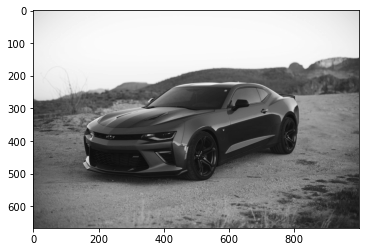

In [18]:
car = cv2.imread('car.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(car, cmap='gray')

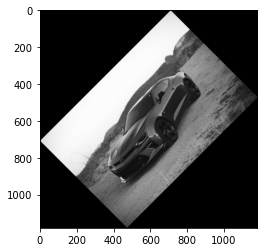

In [19]:
affine_car = cv2.imread('Affine.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(affine_car, cmap='gray')

In [31]:
P = f_getPoints(car, 5)
P = np.vstack((P, np.ones((1,5))))
P

Using matplotlib backend: Qt5Agg


array([[293., 298., 238., 237., 370.],
       [352., 574., 604., 424., 440.],
       [  1.,   1.,   1.,   1.,   1.]])

In [32]:
P_Dash = f_getPoints(affine_car, 5)
P_Dash = np.vstack((P_Dash, np.ones((1,5))))
P_Dash

Using matplotlib backend: Qt5Agg


array([[662., 511., 444., 570., 656.],
       [459., 619., 599., 470., 573.],
       [  1.,   1.,   1.,   1.,   1.]])

In [33]:
Matrix = P_Dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T)))
Matrix

array([[ 7.35288850e-01, -7.00298819e-01,  6.92728117e+02],
       [ 6.86928734e-01,  7.07811939e-01,  7.81371121e+00],
       [-1.38777878e-17,  1.38777878e-17,  1.00000000e+00]])

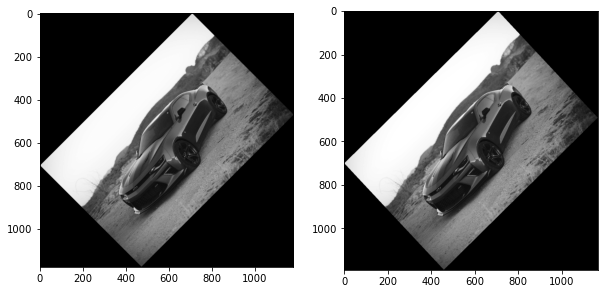

In [34]:
%matplotlib inline
new = f_tranfrom_Projective(Matrix, car)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(affine_car, cmap='gray')

plt.subplot(122)
plt.imshow(new, cmap='gray')

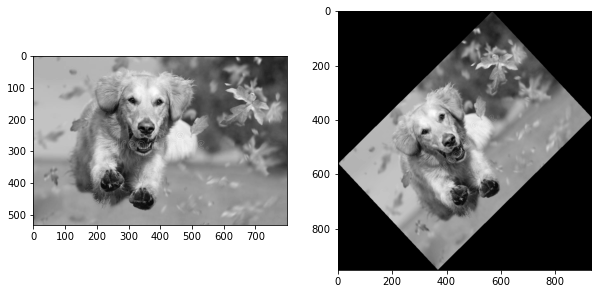

In [36]:
%matplotlib inline
dog = cv2.imread('img2.jpg', cv2.IMREAD_GRAYSCALE)
new = f_tranfrom_Projective(Matrix, dog)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(dog, cmap='gray')

plt.subplot(122)
plt.imshow(new, cmap='gray')

# Estimating Projective Transformation